## Explore the directory

In [27]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_img(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(256, 256))
    return image

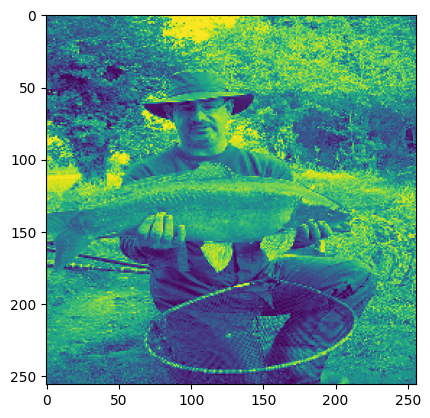

In [28]:
import matplotlib.pyplot as plt

image = load_and_scale_img('../dataset/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_18.JPEG')
plt.imshow(image)

In [29]:
def get_class_names():
    with open('../dataset/ILSVRC/LOC_synset_mapping.txt') as f:
        file_content = f.read()
    file_content = file_content.splitlines()
    class_names = []
    for elem in file_content:
        class_names.append(elem.split(sep="; ")[1])
    return class_names

In [30]:
print(get_class_names())

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus']


## Attempt 1 : Small model

The input shape of our network will be of $256 \times 256$. Thus we will reshape every image to a unified size of $256 \times 256$ pixels.

### Load the data

Here we use a built in Tensorflow function : `tf.keras.preprocessing.image_dataset_from_directory()` that load a directory where each folder is a class containing images belonging to it. 

In [31]:
import tensorflow as tf

dataset_path = '/Users/paul/Library/Mobile Documents/com~apple~CloudDocs/Professionnel/GI04/DS51/ds51_project/dataset/ILSVRC/Data/CLS-LOC/train'

dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, shuffle=True)


Found 13000 files belonging to 10 classes.


In [32]:
for data, labels in dataset.take(1):
    print(data.shape)
    print(labels.shape)


(32, 256, 256, 3)
(32,)


`tf.data.Dataset.take(count)` creates a Dataset with at most `count` elements from this Dataset.


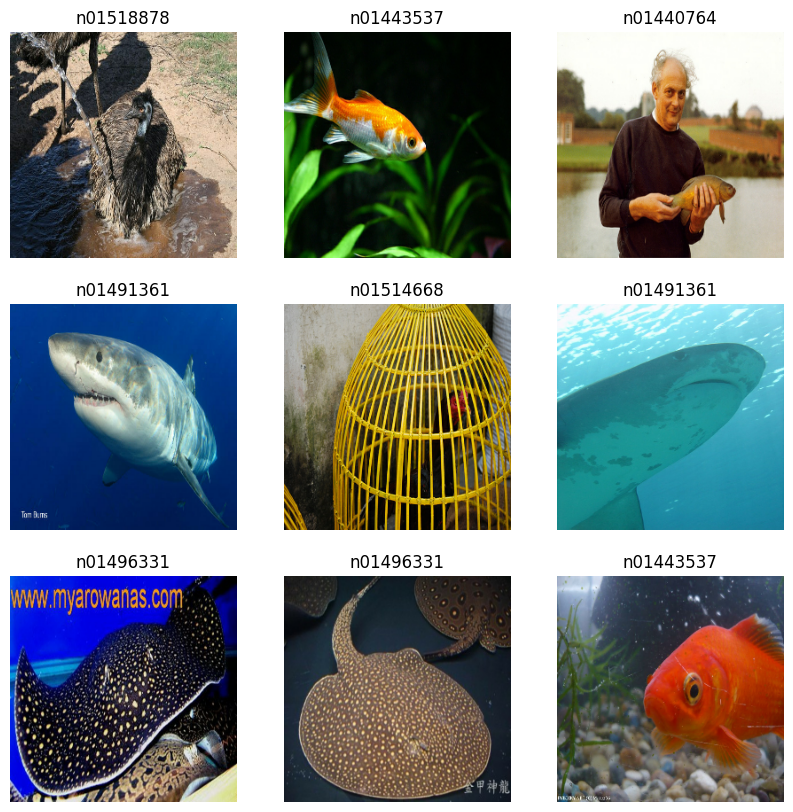

In [33]:
import matplotlib.pyplot as plt

class_names = dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [34]:
dataset_size = 13011
train_size = int(dataset_size * 0.8)

train_data = dataset.take(train_size)
val_data = dataset.skip(train_size)

### Create the Model

Here, we use a small convolutional neural network.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

num_classes = 10

model = Sequential()
model.add(Conv2D(75, (5, 5), strides=5, padding="same", activation="relu",
                 input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((3, 3), strides=2, padding="same"))
model.add(Conv2D(50, (5, 5), strides=5, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((3, 3), strides=5, padding="same"))
model.add(Conv2D(25, (5, 5), strides=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=5, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))


In [36]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [37]:
model.fit(train_data,
          epochs=20,
          validation_data=val_data,
          # verbose=2,
          )


407/407 [==============================] - 19s 45ms/step - loss: 1.8192 - accuracy: 0.3238
Epoch 2/20
407/407 [==============================] - 19s 45ms/step - loss: 1.6590 - accuracy: 0.3775
Epoch 3/20
407/407 [==============================] - 18s 45ms/step - loss: 1.6025 - accuracy: 0.4058
Epoch 4/20
407/407 [==============================] - 18s 45ms/step - loss: 1.5700 - accuracy: 0.4162
Epoch 5/20
407/407 [==============================] - 18s 44ms/step - loss: 1.5357 - accuracy: 0.4335
Epoch 6/20
407/407 [==============================] - 18s 44ms/step - loss: 1.5135 - accuracy: 0.4400
Epoch 7/20
407/407 [==============================] - 19s 46ms/step - loss: 1.5093 - accuracy: 0.4442
Epoch 8/20
407/407 [==============================] - 18s 45ms/step - loss: 1.4936 - accuracy: 0.4511
Epoch 9/20
407/407 [==============================] - 19s 45ms/step - loss: 1.5082 - accuracy: 0.4488
Epoch 10/20
407/407 [==============================] - 18s 44ms/step - loss: 1.5241 - accurac

## Attempt 2 : Small model + Image Generator

### Load the data

Here, we use a generator to perform data augmentation on our original dataset. That is, each image will be slightly altered before being fed in to the model. 

In [ ]:
import tensorflow as tf

In [ ]:
dataset_path = '/Users/paul/Library/Mobile Documents/com~apple~CloudDocs/Professionnel/GI04/DS51/ds51_project/dataset/ILSVRC/Data/CLS-LOC/train'


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # randomly rotate images in the range (degrees, 0 to 180)
    rotation_range=10,
    zoom_range=0.1,  # Randomly zoom image
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # Don't randomly flip images vertically
)


In [ ]:
aug_dataset = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)


### Create the model

We are using a small basic convolutional neural network to analyze our data.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

num_classes = 10

model = Sequential()
model.add(Conv2D(75, (5, 5), strides=5, padding="same", activation="relu",
                 input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((3, 3), strides=2, padding="same"))
model.add(Conv2D(50, (5, 5), strides=5, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((3, 3), strides=5, padding="same"))
model.add(Conv2D(25, (5, 5), strides=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=5, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))


In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(aug_dataset, 
          steps_per_epoch=aug_dataset.samples // aug_dataset.batch_size, 
          epochs=20, 
          # verbose=2,
          )

406/406 [==============================] - 117s 285ms/step - loss: 1.8425 - accuracy: 0.3019
Epoch 2/20
406/406 [==============================] - 117s 288ms/step - loss: 1.7114 - accuracy: 0.3603
Epoch 3/20
406/406 [==============================] - 116s 287ms/step - loss: 1.6513 - accuracy: 0.3865
Epoch 4/20
406/406 [==============================] - 116s 287ms/step - loss: 1.6232 - accuracy: 0.4002
Epoch 5/20
406/406 [==============================] - 120s 294ms/step - loss: 1.6111 - accuracy: 0.4028
Epoch 6/20
406/406 [==============================] - 119s 293ms/step - loss: 1.5956 - accuracy: 0.4125
Epoch 7/20
406/406 [==============================] - 116s 286ms/step - loss: 1.5799 - accuracy: 0.4132
Epoch 8/20
406/406 [==============================] - 116s 286ms/step - loss: 1.5821 - accuracy: 0.4158
Epoch 9/20
406/406 [==============================] - 117s 287ms/step - loss: 1.5763 - accuracy: 0.4175
Epoch 10/20
406/406 [==============================] - 116s 285ms/step - lo

### Conclusion

Using an Image Generator seems to be useless here and leads to very bad performances in training

## Attempt 3 : Larger Model without Data Augmentation

### Load the data

In [1]:
import tensorflow as tf

dataset_path = '/Users/paul/Library/Mobile Documents/com~apple~CloudDocs/Professionnel/GI04/DS51/ds51_project/dataset/ILSVRC/Data/CLS-LOC/train'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, shuffle=True)


Found 13000 files belonging to 10 classes.


2023-06-13 11:32:18.068452: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-06-13 11:32:18.068479: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-13 11:32:18.068489: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-13 11:32:18.068748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-13 11:32:18.068764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
dataset_size = 13011
train_size = int(dataset_size * 0.8)

train_data = dataset.take(train_size)
val_data = dataset.skip(train_size)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

num_classes = 10

model = Sequential()
model.add(Conv2D(75, (64, 64), strides=18, padding="same", activation="relu",
                 input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((5, 5), strides=5, padding="same"))
model.add(Conv2D(50, (32, 32), strides=9, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((18, 18), strides=18, padding="same"))
model.add(Conv2D(25, (32, 32), strides=9, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((18, 18), strides=18, padding="same"))
model.add(Flatten())
model.add(Dense(units=10700, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 15, 75)        921675    
                                                                 
 batch_normalization_3 (Bat  (None, 15, 15, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 75)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 50)          3840050   
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 50)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 1, 1, 50)         

In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [5]:
model.fit(train_data,
          epochs=20,
          validation_data=val_data,
          # verbose=2,
          )

407/407 [==============================] - 88s 214ms/step - loss: 1.8542 - accuracy: 0.2988
Epoch 2/20
407/407 [==============================] - 86s 211ms/step - loss: 1.6643 - accuracy: 0.3690
Epoch 3/20
407/407 [==============================] - 86s 211ms/step - loss: 1.6120 - accuracy: 0.3958
Epoch 4/20
407/407 [==============================] - 86s 211ms/step - loss: 1.5751 - accuracy: 0.4134
Epoch 5/20
407/407 [==============================] - 89s 218ms/step - loss: 1.5561 - accuracy: 0.4204
Epoch 6/20
407/407 [==============================] - 91s 222ms/step - loss: 1.5412 - accuracy: 0.4269
Epoch 7/20
407/407 [==============================] - 91s 223ms/step - loss: 1.5395 - accuracy: 0.4400
Epoch 8/20
407/407 [==============================] - 88s 216ms/step - loss: 1.5520 - accuracy: 0.4349
Epoch 9/20
407/407 [==============================] - 87s 213ms/step - loss: 1.5572 - accuracy: 0.4405
Epoch 10/20
407/407 [==============================] - 88s 215ms/step - loss: 1.5730